# Space

In [1]:
import os
import sys 
import logging
import random
import pandas as pd 
from pprint import pprint 
from IPython.display import display, HTML

# WorkSpace
KEY = 'WorkSpace'; WORKSPACE_PATH = os.getcwd().split(KEY)[0] + KEY; print(WORKSPACE_PATH)
os.chdir(WORKSPACE_PATH)
sys.path.append(WORKSPACE_PATH)

# Pipeline Space
from proj_space import SPACE
SPACE['WORKSPACE_PATH'] = WORKSPACE_PATH
sys.path.append(SPACE['CODE_FN'])
pprint(SPACE)


# Available Packages
import argparse
import datasets
import pandas as pd
from datetime import datetime 

from recfldtkn.ckpd_obs import Ckpd_ObservationS
from recfldtkn.configfn import load_cohort_args
from recfldtkn.loadtools import update_args_to_list

logger = logging.getLogger(__name__)
recfldtkn_config_path = os.path.join(SPACE['CODE_RFT'], 'config_recfldtkn/')

/Users/floydluo/Library/CloudStorage/OneDrive-DRFIRST.COM,INC/Documents - DrFirst-JHU Collaboration Center/DrFirst-Project/2024-DrFirst-v2-SPACE/_DrFirst-AI-EduRxPred-WorkSpace
{'CODE_FN': '../pipeline',
 'CODE_RFT': '../pipeline',
 'DATA_CaseObs': '../_Data/2-Data_CaseObs',
 'DATA_RAW': '../_Data/0-Data_Raw',
 'DATA_RFT': '../_Data/1-Data_RFT',
 'DATA_TASK': 'Data_EduRxPred',
 'MODEL_TASK': 'Model_EduRxPred',
 'WORKSPACE_PATH': '/Users/floydluo/Library/CloudStorage/OneDrive-DRFIRST.COM,INC/Documents '
                   '- DrFirst-JHU Collaboration '
                   'Center/DrFirst-Project/2024-DrFirst-v2-SPACE/_DrFirst-AI-EduRxPred-WorkSpace'}


# Args

In [2]:
case_observations = [
    'FutEduTknY:ro.EgmEdu-Af1W_ct.FutRxEduTkn',  
    
    'PDemo:ro.P-Demo_ct.InCaseTkn',
    'PZip3Demo:ro.P-Zip3DemoNume_ct.InCaseTkn',
    'PZip3Econ:ro.P-Zip3EconNume_ct.InCaseTkn',
    'PZip3House:ro.P-Zip3HousingNume_ct.InCaseTkn',
    'PZip3Social:ro.P-Zip3SocialNume_ct.InCaseTkn',
    'RxInCase1:ro.Rx-InObs-CmpCate_ct.InCaseTkn',
    'RxInCase2:ro.Rx-InObs-InsCate_ct.InCaseTkn',
    'RxInCase3:ro.Rx-InObs-QuantN2C_ct.InCaseTkn',
    'RxInCase4:ro.Rx-InObs-QuantNume_ct.InCaseTkn',
    'RxInCase5:ro.Rx-InObs-ServiceCate_ct.InCaseTkn',
    'RxInCase6:ro.Rx-InObs-SysCate_ct.InCaseTkn',
    'RxInObsNum:ro.Rx-InObs_ct.RecNum',
]
case_taskop = 'EduRxMLPred'

In [3]:
from recfldtkn.loadtools import consistent_short_hash
CO_list_hash = consistent_short_hash(tuple(sorted(case_observations)))
CO_list_hash 

'lKZ5K9opNW'

In [5]:
CaseTaskOp = case_taskop

AI_InputOutput_ModelFolder = os.path.join(SPACE['MODEL_TASK'], CaseTaskOp + f'-CO_{CO_list_hash}')
print(AI_InputOutput_ModelFolder)

#############################
caseset_name = 'TrulicityRx'
split_name = 'rs42-ds1-out0ts2023.11.01vd0.1'
#############################

dataset_name = os.path.join(AI_InputOutput_ModelFolder, 'AIDataset', caseset_name + '-' + split_name)
print(dataset_name)

Model_EduRxPred/EduRxMLPred-CO_lKZ5K9opNW
Model_EduRxPred/EduRxMLPred-CO_lKZ5K9opNW/AIDataset/TrulicityRx-rs42-ds1-out0ts2023.11.01vd0.1


## [Step] Training Set and Evaluation Set

In [6]:
train_set_selector = "in_train"
# train_set_selector = "split:in_train|subgroup:all|subgroupfilter:age_geq60"

eval_set_selectors = [
    "in_valid",
    "in_test",
    # "split:in_valid|subgroup:2|subgroupfilter:zip_from_poor_area",
    # "split:in_test|subgroup:1|subgroupfilter:age_geq60",
]

In [7]:

CaseFolder = os.path.join(SPACE['DATA_TASK'], 'CaseFolder', caseset_name)
print(CaseFolder)
total_groupname_list = sorted([i for i in os.listdir(CaseFolder)])
print(total_groupname_list)

idx_to_groupname_all = dict(sorted({int(v.split('_')[0]): v.split('.')[0] for v in total_groupname_list}.items()))
idx_to_groupname_all

Data_EduRxPred/CaseFolder/TrulicityRx
['0_C1-gF-Ab50.p', '1_C1-gF-Bl50.p', '2_C1-gM-Ab50.p', '3_C1-gM-Bl50.p', '4_None.p']


{0: '0_C1-gF-Ab50',
 1: '1_C1-gF-Bl50',
 2: '2_C1-gM-Ab50',
 3: '3_C1-gM-Bl50',
 4: '4_None'}

In [8]:
from datasets import concatenate_datasets

def get_dataset_from_set_selector(set_selector, dataset_name, idx_to_groupname_all):
    # for train_set 
    groupname_dict = idx_to_groupname_all.copy()

    ds_subset_name = set_selector.split(':')[0]
    # print(ds_subset_name)
    ds_subset_name_list_all = ['in_train', 'in_valid', 'in_test', 'out_test', 'out_train', 'out_valid']
    ds_subset_name_list = [i for i in ds_subset_name_list_all if ds_subset_name in i]

    if ':' in set_selector:
        groupname_types = set_selector.split(':')[-1].split('&')
        # print(groupname_types)
        for groupname_type in groupname_types:
            # print(groupname_type)
            groupname_dict = {k: v for k, v in groupname_dict.items() if groupname_type in v}

    # print('the number of group:', len(groupname_dict))

    L = []
    for ds_subset_name in ds_subset_name_list:
        for idx, groupname in groupname_dict.items():
            if 'CaseFolder' not in dataset_name:
                path = os.path.join(dataset_name + '-' + ds_subset_name, groupname)
                # print(path)
                if os.path.exists(path) == False: continue
                ds = datasets.load_from_disk(path)
                print(groupname, len(ds))
            else:
                path = os.path.join(dataset_name + '-' + ds_subset_name, groupname + '.p')
                # print(path)
                if os.path.exists(path) == False: continue
                df = pd.read_pickle(path)
                ds = datasets.Dataset.from_pandas(df)
                print(groupname, len(ds))
            # print([i for i in ds])
            # ds = {k: v for k, v in ds.items() if ds_subset_name in k}
            # if ds_subset_name not in ds: continue
            # if len(ds) == 0: continue 
            # if len(ds) == 0:
            #     ds_subset_name_dataset = [v for k, v in ds.items()][0]
            # else:
            #     ds_subset_name_dataset = concatenate_datasets([v for k, v in ds.items()])
            # print(groupname, len(ds_subset_name_dataset))
            L.append(ds)
    if len(L) > 0:
        ds = concatenate_datasets(L)
    else:
        ds = None 
    return ds

In [9]:
set_selector = train_set_selector

set_selector = 'in_train'

print(set_selector)
ds = get_dataset_from_set_selector(set_selector, dataset_name, idx_to_groupname_all)
ds

in_train
0_C1-gF-Ab50 34256
1_C1-gF-Bl50 14960
2_C1-gM-Ab50 27424
3_C1-gM-Bl50 8813
4_None 51


Dataset({
    features: ['input_ids', 'input_wgts', 'labels', 'label_wgts'],
    num_rows: 85504
})

In [10]:
set_selector = train_set_selector
for set_selector in ['in_train',  ]:
    print(f'\n=================== {set_selector} ======================')
    train_raw_dataset = get_dataset_from_set_selector(set_selector, dataset_name, idx_to_groupname_all)
    print(train_raw_dataset)

evalname_to_set = {}
for set_selector in eval_set_selectors:
    print(f'\n=================== {set_selector} ======================')
    eval_raw_dataset = get_dataset_from_set_selector(set_selector, dataset_name, idx_to_groupname_all)
    evalname_to_set[set_selector] = eval_raw_dataset
    print(eval_raw_dataset)



=================== in_train ======================
0_C1-gF-Ab50 34256
1_C1-gF-Bl50 14960
2_C1-gM-Ab50 27424
3_C1-gM-Bl50 8813
4_None 51
Dataset({
    features: ['input_ids', 'input_wgts', 'labels', 'label_wgts'],
    num_rows: 85504
})

=================== in_valid ======================
0_C1-gF-Ab50 3704
1_C1-gF-Bl50 1609
2_C1-gM-Ab50 2913
3_C1-gM-Bl50 1031
4_None 4
Dataset({
    features: ['input_ids', 'input_wgts', 'labels', 'label_wgts'],
    num_rows: 9261
})

=================== in_test ======================
0_C1-gF-Ab50 2557
1_C1-gF-Bl50 1107
2_C1-gM-Ab50 1876
3_C1-gM-Bl50 699
4_None 2
Dataset({
    features: ['input_ids', 'input_wgts', 'labels', 'label_wgts'],
    num_rows: 6241
})


In [11]:
train_raw_dataset

Dataset({
    features: ['input_ids', 'input_wgts', 'labels', 'label_wgts'],
    num_rows: 85504
})

In [12]:
evalname_to_set

{'in_valid': Dataset({
     features: ['input_ids', 'input_wgts', 'labels', 'label_wgts'],
     num_rows: 9261
 }),
 'in_test': Dataset({
     features: ['input_ids', 'input_wgts', 'labels', 'label_wgts'],
     num_rows: 6241
 })}

# ML (baseline)

## 1. Tokenizer

In [13]:
tokenizer_seq_list = [i.replace('.json', '') for i in os.listdir(AI_InputOutput_ModelFolder) if '.json' in i]
tokenizer_seq_list

['labels', 'input_ids']

In [15]:
import tokenizers

seq_to_tokenizer = {}
for seq in tokenizer_seq_list:
    # print(tokenizer_seq)
    tokenizer_seq_path = os.path.join(AI_InputOutput_ModelFolder, seq + '.json')
    print(tokenizer_seq_path)
    tokenizer_seq = tokenizers.Tokenizer.from_file(tokenizer_seq_path)
    seq_to_tokenizer[seq] = tokenizer_seq

seq_to_tokenizer

Model_EduRxPred/EduRxMLPred-CO_lKZ5K9opNW/labels.json
Model_EduRxPred/EduRxMLPred-CO_lKZ5K9opNW/input_ids.json


{'labels': <tokenizers.Tokenizer at 0x7f9d9095a830>,
 'input_ids': <tokenizers.Tokenizer at 0x7f9d9095a030>}

In [16]:
for seq, tokenizer_seq in seq_to_tokenizer.items():
    print(seq)
    print(tokenizer_seq.get_vocab_size())

labels
7
input_ids
543


## 1. Starting from One DS

In [17]:
ds = train_raw_dataset
ds

Dataset({
    features: ['input_ids', 'input_wgts', 'labels', 'label_wgts'],
    num_rows: 85504
})

## 2. X Feature for One DS

In [18]:
seq = 'input_ids'

tokenizer_seq = seq_to_tokenizer[seq]
tkn2tid = tokenizer_seq.get_vocab()
tid2tkn = dict(sorted({v: k for k, v in tkn2tid.items()}.items()))
num_features = len(tid2tkn)
print(num_features)

543


In [19]:
from scipy.sparse import csr_matrix
from tqdm import tqdm

# Function to create CSR matrix
def create_csr_matrix(dataset, num_features):
    row_indices = []
    col_indices = []
    data = []
    
    for i, example in enumerate(dataset):
        input_ids = example['input_ids']
        input_wgts = example['input_wgts']
        row_indices.extend([i] * len(input_ids))
        col_indices.extend(input_ids)
        data.extend(input_wgts)

    sparse_matrix_value = (data, (row_indices, col_indices))
    shape = (len(dataset), num_features)
    return csr_matrix(sparse_matrix_value, shape=shape)

In [20]:
X = create_csr_matrix(ds, num_features)
print(X.shape)

(85504, 543)


# 3. Y Label for one DS

In [21]:
seq = 'labels'

tokenizer_seq = seq_to_tokenizer[seq]
tkn2tid = tokenizer_seq.get_vocab()
tid2tkn = dict(sorted({v: k for k, v in tkn2tid.items()}.items()))
num_features = len(tid2tkn)
print(num_features)
tid2tkn

7


{0: 'FutEduTknY:unk',
 1: 'FutEduTknY:InvBtnEgm',
 2: 'FutEduTknY:InvBtnEgmClicks',
 3: 'FutEduTknY:InvMinsUntil1stEgm',
 4: 'FutEduTknY:RxBtnEgm',
 5: 'FutEduTknY:RxBtnEgmClicks',
 6: 'FutEduTknY:RxMinsUntil1stEgm'}

In [22]:
# Define the specific label ID you are interested in
Y_label = 'FutEduTknY:RxBtnEgm' # 'FutEduTknY:InvBtnEgm'
Y_id = tkn2tid[Y_label]
Y_id

4

In [23]:
def get_y_label(example, Y_id):
    # Create a dictionary from 'labels' and 'label_wgts'
    d = dict(zip(example['labels'], example['label_wgts']))
    # Get the label weight for the specified Y_id
    y_label = d.get(Y_id, None)  # Using .get for safe access
    return {'y_label': y_label}


In [24]:
ds = ds.map(lambda example: get_y_label(example, Y_id), batched=False)
Y = ds['y_label']
len(Y)

Map:   0%|          | 0/85504 [00:00<?, ? examples/s]

85504

In [25]:
import numpy as np
np.array(Y).mean()

0.026185909431137723

# Functions to get X and Y

In [26]:
def get_X_Y_pair_from_dataset(ds, seq_to_tokenizer, Y_label):
    seq = 'input_ids'
    
    tokenizer_seq = seq_to_tokenizer[seq]
    tkn2tid = tokenizer_seq.get_vocab()
    tid2tkn = dict(sorted({v: k for k, v in tkn2tid.items()}.items()))
    num_features = len(tid2tkn)
    # print(num_features) 
    X = create_csr_matrix(ds, num_features)

    seq = 'labels'
    tokenizer_seq = seq_to_tokenizer[seq]
    tkn2tid = tokenizer_seq.get_vocab()
    tid2tkn = dict(sorted({v: k for k, v in tkn2tid.items()}.items()))
    Y_id = tkn2tid[Y_label]
    ds = ds.map(lambda example: get_y_label(example, Y_id), batched=False)
    Y = ds['y_label']
    return X, Y

In [27]:
Y_label = 'FutEduTknY:RxBtnEgm' # 'FutEduTknY:InvBtnEgm'

X, Y = get_X_Y_pair_from_dataset(ds, seq_to_tokenizer, Y_label)

Map:   0%|          | 0/85504 [00:00<?, ? examples/s]

In [28]:
import xgboost as xgb
dXGBoost = xgb.DMatrix(X, label=Y)

## Prepare X Y for all Sets

In [29]:
import xgboost as xgb
Y_label = 'FutEduTknY:RxBtnEgm' # 'FutEduTknY:InvBtnEgm'

In [30]:
ds = train_raw_dataset
X, Y = get_X_Y_pair_from_dataset(ds, seq_to_tokenizer, Y_label)
dtrain = xgb.DMatrix(X, label=Y)

Map:   0%|          | 0/85504 [00:00<?, ? examples/s]

In [31]:
evalname_to_set

{'in_valid': Dataset({
     features: ['input_ids', 'input_wgts', 'labels', 'label_wgts'],
     num_rows: 9261
 }),
 'in_test': Dataset({
     features: ['input_ids', 'input_wgts', 'labels', 'label_wgts'],
     num_rows: 6241
 })}

In [32]:
eval_to_dXGBoost = {}
for eval_name, ds in evalname_to_set.items():
    X, Y = get_X_Y_pair_from_dataset(ds, seq_to_tokenizer, Y_label)
    dXGboost = xgb.DMatrix(X, label=Y)
    eval_to_dXGBoost[eval_name] = dXGboost

eval_to_dXGBoost

Map:   0%|          | 0/9261 [00:00<?, ? examples/s]

Map:   0%|          | 0/6241 [00:00<?, ? examples/s]

{'in_valid': <xgboost.core.DMatrix at 0x7f9d908c1490>,
 'in_test': <xgboost.core.DMatrix at 0x7f9d90945070>}

# Train Models

In [33]:
params = {
    'max_depth': 5,
    'eta': 0.1,
    'objective': 'binary:logistic',  
    'eval_metric': 'logloss',  
}
num_boost_round = 300

evals_result = {}
bst = xgb.train(params, 
                dtrain, 
                num_boost_round, 
                evals=[(dtrain, 'train')] + [(v, k) for k, v in eval_to_dXGBoost.items()], 
                
                evals_result=evals_result, 
                
                verbose_eval=True)

[0]	train-logloss:0.60718	in_valid-logloss:0.60710	in_test-logloss:0.59844
[1]	train-logloss:0.53681	in_valid-logloss:0.53667	in_test-logloss:0.52088
[2]	train-logloss:0.47825	in_valid-logloss:0.47805	in_test-logloss:0.45619
[3]	train-logloss:0.42889	in_valid-logloss:0.42867	in_test-logloss:0.40151
[4]	train-logloss:0.38691	in_valid-logloss:0.38663	in_test-logloss:0.35480
[5]	train-logloss:0.35089	in_valid-logloss:0.35055	in_test-logloss:0.31458
[6]	train-logloss:0.31982	in_valid-logloss:0.31944	in_test-logloss:0.27968
[7]	train-logloss:0.29287	in_valid-logloss:0.29246	in_test-logloss:0.24925
[8]	train-logloss:0.26941	in_valid-logloss:0.26896	in_test-logloss:0.22259
[9]	train-logloss:0.24891	in_valid-logloss:0.24848	in_test-logloss:0.19913
[10]	train-logloss:0.23095	in_valid-logloss:0.23049	in_test-logloss:0.17842
[11]	train-logloss:0.21519	in_valid-logloss:0.21467	in_test-logloss:0.16009
[12]	train-logloss:0.20132	in_valid-logloss:0.20079	in_test-logloss:0.14382
[13]	train-logloss:0.1

In [34]:
bst

## Evaluation

In [35]:
[i for i in evals_result]

['train', 'in_valid', 'in_test']

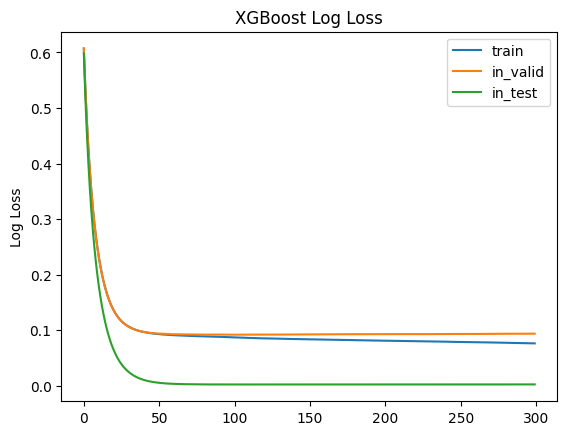

In [36]:
import matplotlib.pyplot as plt
# print("Evaluation Results:", evals_result)

epochs = len(evals_result['train']['logloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()

for splitname in evals_result:
    ax.plot(x_axis, evals_result[splitname]['logloss'], label=splitname)

ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

In [ ]:
# ObsDT

# 2023-11-01 ---> test (0.01%). Case Obs 11-23. 
# 2023-11-01 ---> valid (2.5) & train (2.7) 0.9 vs 0.1

In [38]:
for spliteval, dEval in eval_to_dXGBoost.items():
    print(spliteval)
    print(dEval)

in_valid
in_test


in_valid
Mean of Real Y: 0.024835331365466118
Accuracy: 0.9641507396609438
Precision: 0.18518518518518517
Recall: 0.13043478260869565
F1 Score: 0.15306122448979595
ROC-AUC: 0.8522540717239653


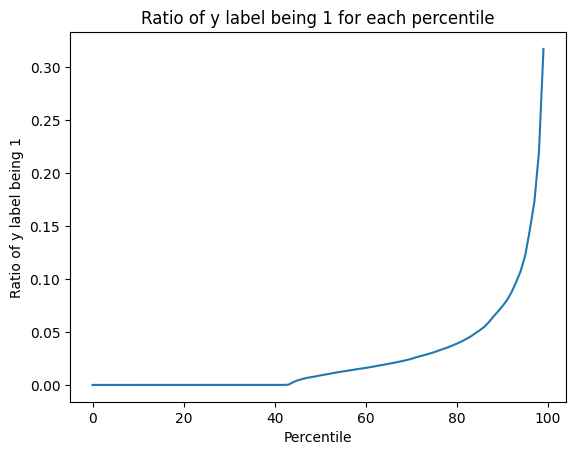

in_test
Mean of Real Y: 0.000640922924503684
Accuracy: 0.9990386156064733
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC-AUC: 0.9962321628988295


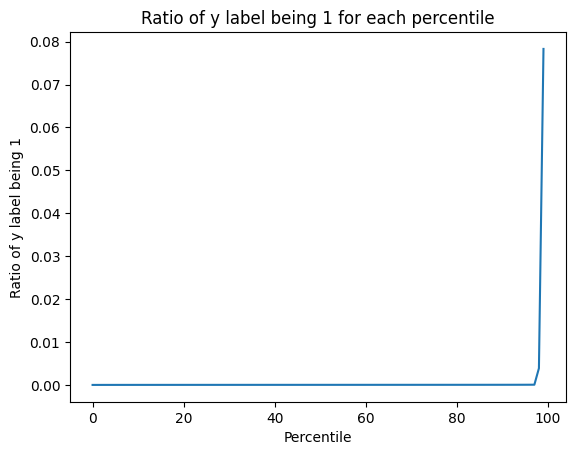

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


# For binary classification, convert probabilities to binary predictions (0 or 1)
threshold = 0.2  # This threshold can be adjusted based on your requirements

for spliteval, dEval in eval_to_dXGBoost.items():
    print(spliteval)
    print(dEval)

    y_pred = bst.predict(dEval)
    y_pred_binary = [1 if prob > threshold else 0 for prob in y_pred]
    y_real = dEval.get_label()

    assert len(y_real) == len(y_pred_binary)

    # Calculate metrics
    accuracy = accuracy_score(y_real, y_pred_binary)
    precision = precision_score(y_real, y_pred_binary)
    recall = recall_score(y_real, y_pred_binary)
    f1 = f1_score(y_real, y_pred_binary)
    roc_auc = roc_auc_score(y_real, y_pred)

    # Print metrics
    mean_y_real = np.mean(y_real)
    print(f"Mean of Real Y: {mean_y_real}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC-AUC: {roc_auc}")

    y_pred_list = y_pred.tolist()

    # Create a DataFrame
    df_y = pd.DataFrame({
        'Actual': y_real,
        'Predicted': y_pred_list
    })

    # Sort the DataFrame based on the 'Predicted' column
    df_ysorted = df_y.sort_values(by='Predicted', ascending=False) 
    df_ysorted.head(20)

    # For each percentile: i% to i + 1 %, report its the ratio of that y label is 1.
    # Calculate the percentile for each row based on the 'Predicted' column
    df_ysorted['Percentile'] = pd.qcut(df_ysorted['Predicted'], 100, labels=False)

    # Calculate the ratio of y label being 1 for each percentile
    percentile_ratios = []
    for i in range(100):
        percentile_data = df_ysorted[df_ysorted['Percentile'] == i]
        ratio = np.mean(percentile_data['Predicted'])
        percentile_ratios.append(ratio)

    # # Print the ratios for each percentile
    # for i, ratio in enumerate(percentile_ratios):
    #     print(f"Percentile {i+1}-{i+2}: {ratio}")

    # Plot the ratios
    plt.plot(percentile_ratios)
    plt.xlabel('Percentile')
    plt.ylabel('Ratio of y label being 1')
    plt.title('Ratio of y label being 1 for each percentile')
    plt.show()

# TODO: AUC
# Select the best thresold. 

# DL

# pytorch / huggingface